In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import composition
import utils

In [2]:
df = pd.read_csv("/Users/umakantmanore/Desktop/amu/Dev_Enviroment2023/test_env/Material_Properties/materials.csv")

uncleaned_formulae = df['ENTRY ']
cleaned_formulae = []


In [3]:
for cell_value in uncleaned_formulae:
    split_list = cell_value.split(" [")
    clean_formula = split_list[0]
    cleaned_formulae.append(clean_formula)

df_cleaned = pd.DataFrame()
df_cleaned['formula'] = cleaned_formulae

In [4]:
# Define all target properties you want to predict
target_properties = ['AEL VRH bulk modulus ', 'AEL elastic anisotropy ',
       'AEL Poisson ratio ', 'AEL VRH shear modulus ']

for prop in target_properties:
    df_cleaned[prop] = df[prop]


print(df_cleaned)

         formula  AEL VRH bulk modulus   AEL elastic anisotropy   \
0      Ag10S8Sb2                35.2376                 0.440193   
1       Ag1Al1S2                71.6539                 1.125370   
2        Ag1C2K1                27.2627                21.340800   
3       Ag1C2Li1                36.3669                21.700800   
4      Ag1In5Se8                24.7673                 1.487440   
...          ...                    ...                      ...   
2377  Sn2Te10Tl4                19.8206                 0.876004   
2378   Sn2Te6Tl8                27.7128                 0.129837   
2379    Sn4Y2Zn2                60.5576                 0.302202   
2380    Sn4Y4Zn4                63.7756                 0.578253   
2381     Sn6V6Y1               112.3460                 0.162353   

      AEL Poisson ratio   AEL VRH shear modulus   
0               0.350433                11.70820  
1               0.302537                32.58790  
2               0.289897      

In [5]:
df_cleaned.columns = ['formula', 'Bulk modulus', 'Elastic anisotropy', 'Poisson ratio', 'Shear modulus']
df_cleaned

,formula,Bulk modulus,Elastic anisotropy,Poisson ratio,Shear modulus
0,Ag10S8Sb2,35.2376,0.440193,0.350433,11.70820
1,Ag1Al1S2,71.6539,1.125370,0.302537,32.58790
2,Ag1C2K1,27.2627,21.340800,0.289897,13.32190
3,Ag1C2Li1,36.3669,21.700800,0.297220,17.05450
4,Ag1In5Se8,24.7673,1.487440,0.274498,13.14660
...,...,...,...,...,...
2377,Sn2Te10Tl4,19.8206,0.876004,0.299423,9.17845
2378,Sn2Te6Tl8,27.7128,0.129837,0.272139,14.89140
2379,Sn4Y2Zn2,60.5576,0.302202,0.276657,31.78240
2380,Sn4Y4Zn4,63.7756,0.578253,0.224152,43.11320


In [6]:
X, y, formulae = composition.generate_muliple_features(df_cleaned)

The element: Pu from formula C8Pu4W4 is not currently supported in our database


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [8]:
scalar = StandardScaler()
normalizer = Normalizer()

X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)
X_train_scaled = normalizer.fit_transform(X_train_scaled)
X_test_scaled = normalizer.transform(X_test_scaled)

In [9]:
base_model = MultiOutputRegressor(SVR())

In [10]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)
c_parameters = np.logspace(-1, 3, 5)
gamma_parameters = np.logspace(-2, 2, 5)

parameter_candidates = {
    'estimator__C': c_parameters, 
    'estimator__gamma': gamma_parameters
}

grid = GridSearchCV(estimator=base_model, param_grid=parameter_candidates, cv=cv)
grid.fit(X_train_scaled, y_train)

best_parameters = grid.best_params_
print(best_parameters)

{'estimator__C': 100.0, 'estimator__gamma': 1.0}


[]

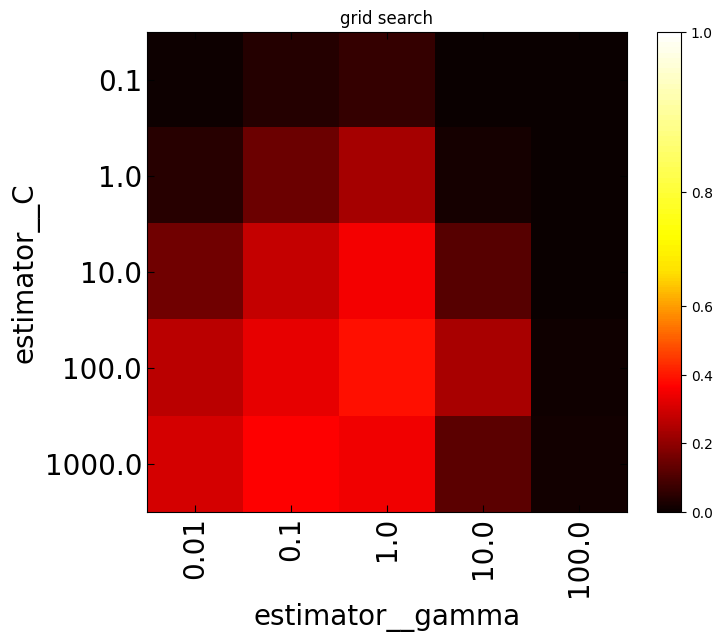

In [11]:
utils.plot_2d_grid_search(grid, midpoint=0.7, vmin=-0, vmax=1)
plt.plot()

R2 score for AEL VRH bulk modulus : 0.9062265025620301
RMSE for AEL VRH bulk modulus : 18.19194852489154
R2 score for AEL elastic anisotropy : 0.5624586998513874
RMSE for AEL elastic anisotropy : 1.7548890527825172
R2 score for AEL Poisson ratio : 0.26556900695733066
RMSE for AEL Poisson ratio : 0.0434243889714574
R2 score for AEL VRH shear modulus : 0.8184714975419285
RMSE for AEL VRH shear modulus : 14.73596247331214


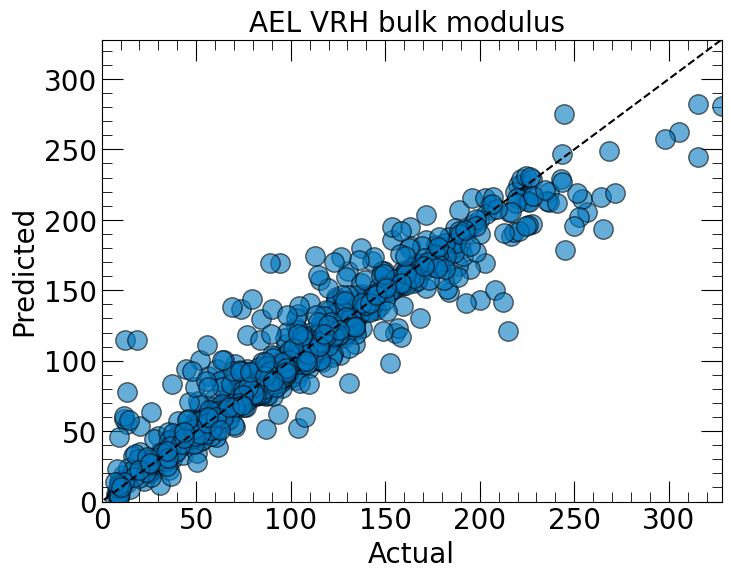

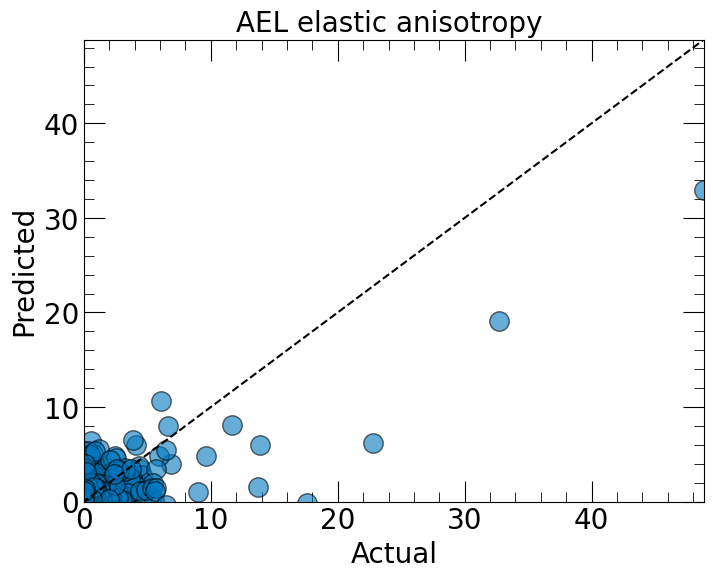

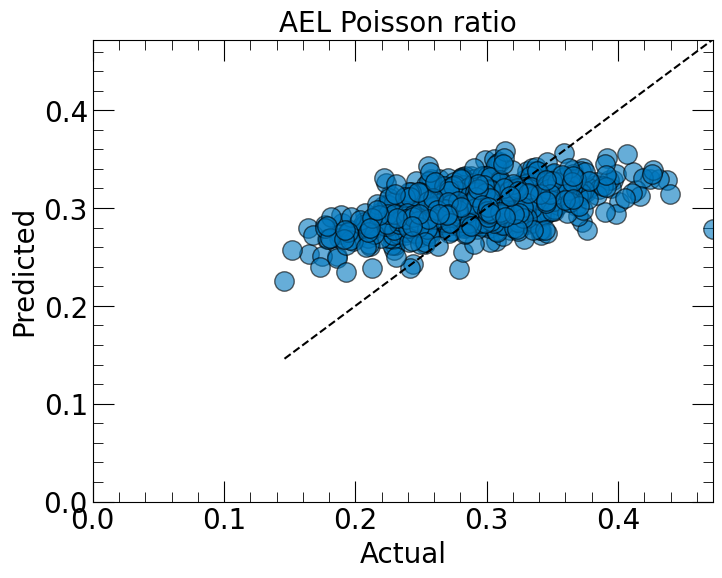

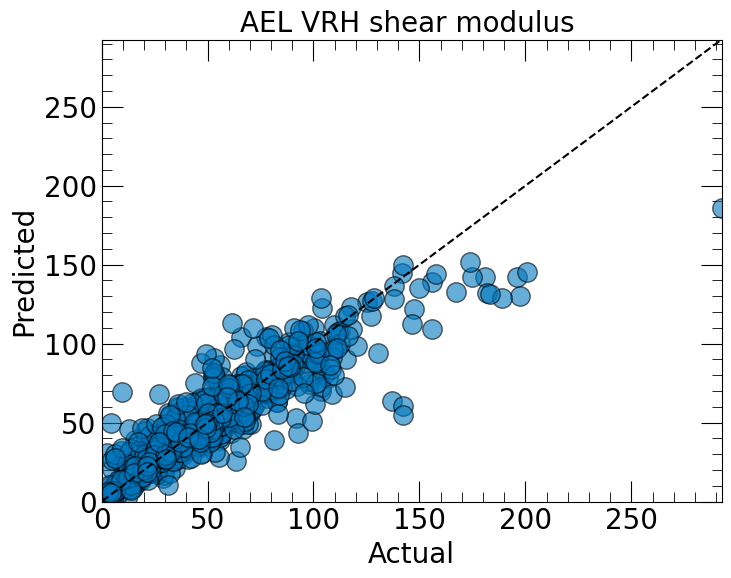

In [12]:
final_model = MultiOutputRegressor(SVR(C=best_parameters['estimator__C'], 
                                       gamma=best_parameters['estimator__gamma']))
final_model.fit(X_train_scaled, y_train)
y_test_predicted = final_model.predict(X_test_scaled)

# Ensure y_test and y_test_predicted are numpy arrays
y_test = np.array(y_test)
y_test_predicted = np.array(y_test_predicted)

# Plotting actual vs predicted for each property
for i, prop in enumerate(target_properties):
    utils.plot_act_vs_pred(y_test[:, i], y_test_predicted[:, i], title=f'{prop}')
    score = r2_score(y_test[:, i], y_test_predicted[:, i])
    rmse = np.sqrt(mean_squared_error(y_test[:, i], y_test_predicted[:, i]))
    print(f"R2 score for {prop}: {score}")
    print(f"RMSE for {prop}: {rmse}")

Bulk Modulus:

R² Score: 0.906 - This indicates a strong correlation between the predicted and actual values. The model explains about 90.6% of the variance in the bulk modulus predictions.
RMSE: 18.192 - This reflects the average error magnitude in the predictions. A lower RMSE is better, but whether this is acceptable depends on the context and scale of your data.

Elastic Anisotropy:

R² Score: 0.562 - This indicates a moderate correlation. The model explains about 56.2% of the variance, suggesting room for improvement.
RMSE: 1.755 - This value suggests a moderate error magnitude in the predictions.

Poisson Ratio:

R² Score: 0.266 - This indicates a weak correlation. The model only explains about 26.6% of the variance, which suggests the model is not performing well for this property.
RMSE: 0.043 - This reflects the average error magnitude, which seems relatively low but is not very informative without context for the Poisson ratio's scale.

Shear Modulus:

R² Score: 0.818 - This indicates a strong correlation between predicted and actual values. The model explains about 81.8% of the variance.
RMSE: 14.736 - This reflects the average error magnitude in the predictions. As with bulk modulus, a lower RMSE would be better depending on your data's scale.


Recommendations:

Feature Engineering: Consider exploring additional features or improving existing ones. Sometimes, feature engineering can significantly boost model performance.

Model Selection: If you find that the current model is underperforming on specific properties, you might want to try different algorithms or fine-tune hyperparameters further.

Data Quality: Ensure that your data is clean and that any preprocessing steps are correctly implemented. Inaccurate data can lead to poor model performance.

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the model
rf = RandomForestRegressor()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Define the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Predict with the best model
best_rf = grid_search.best_estimator_
y_test_predicted = best_rf.predict(X_test_scaled)

# Evaluate the model
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(y_test, y_test_predicted)
rmse = np.sqrt(mean_squared_error(y_test, y_test_predicted))

print("R2 score:", r2)
print("RMSE:", rmse)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  31.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  32.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  32.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  32.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  33.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  59.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  59.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; tot

To improve your model's performance, especially where it's currently underperforming, here are some strategies you can consider:

1. Feature Engineering
Add New Features: Explore adding features derived from existing ones or using domain knowledge to create meaningful features.
Feature Selection: Identify and retain the most important features. Techniques like Recursive Feature Elimination (RFE) or feature importance from tree-based models can help.
Interaction Features: Consider adding interaction terms between features if you believe there are non-linear relationships between them.
2. Data Preprocessing
Normalization/Standardization: Ensure your data is appropriately scaled. Some algorithms perform better when features are scaled to a similar range.
Handle Outliers: Outliers can distort model training. Use techniques to detect and manage outliers.
Data Augmentation: If possible, increase the diversity of your training data.
3. Model Selection and Tuning
Try Different Algorithms: Besides SVR, you might want to experiment with other regression models, such as Random Forest Regressor, Gradient Boosting Regressor, or Neural Networks.
Hyperparameter Tuning: Perform a thorough hyperparameter search. Ensure your grid search or random search covers a wide range of hyperparameters.
Ensemble Methods: Combine predictions from multiple models to potentially improve accuracy.
4. Cross-Validation
Use Proper Validation Techniques: Ensure you're using an appropriate cross-validation technique, such as k-fold cross-validation, to evaluate model performance.
Check for Overfitting: Ensure that your model generalizes well to unseen data and is not just memorizing the training data.
5. Model Evaluation
Additional Metrics: Use other metrics (e.g., Mean Absolute Error (MAE), R² score) to get a comprehensive understanding of model performance.
Residual Analysis: Analyze residuals to identify patterns that the model may not be capturing.
6. Algorithm-Specific Tips for SVR
Kernel Choice: Experiment with different kernels (e.g., linear, polynomial, RBF) in SVR.
Regularization Parameter (C): Adjust the C parameter to find the right balance between model complexity and training error.
Kernel Coefficient (gamma): Tune gamma for RBF and polynomial kernels to improve performance.

In [ ]:
class MaterialsModel():
    def __init__(self, trained_model, scalar, normalizer, properties):
        self.model = trained_model
        self.scalar = scalar
        self.normalizer = normalizer
        self.properties = properties

    def predict(self, formula):
        if isinstance(formula, str):
            df_formula = pd.DataFrame({'formula': [formula], 'target': [0]*len(self.properties)})
        elif isinstance(formula, list):
            df_formula = pd.DataFrame({'formula': formula, 'target': np.zeros(len(formula))})

        X, _, formula = composition.generate_features(df_formula)
        X_scaled = self.scalar.transform(X)
        X_scaled = self.normalizer.transform(X_scaled)
        y_predicted = self.model.predict(X_scaled)

        prediction = pd.DataFrame(formula)
        for i, prop in enumerate(self.properties):
            prediction[prop] = y_predicted[:, i]
        return prediction

bulk_modulus_model = MaterialsModel(final_model, scalar, normalizer, target_properties)

formulae_to_predict = ['NaCl', 'Pu2O4', 'NaNO3']
bulk_modulus_prediction = bulk_modulus_model.predict(formulae_to_predict)
print(bulk_modulus_prediction)